In [1]:
import os

from beamline34IDC.simulation.facade import Implementors
from beamline34IDC.simulation.facade.focusing_optics_factory import focusing_optics_factory_method
from beamline34IDC.simulation.facade.focusing_optics_interface import Movement, AngularUnits

from beamline34IDC.util.shadow.common import plot_shadow_beam_spatial_distribution, load_shadow_beam, PreProcessorFiles
from beamline34IDC.util import clean_up

In [2]:
os.chdir("/gpfs/fs1/home/skandel/code/oasys_ml/ML_Control_System/work_directory")
os.getcwd()

'/gpfs/fs1/home/skandel/code/oasys_ml/ML_Control_System/work_directory'

In [3]:
clean_up()

In [4]:
input_beam = load_shadow_beam("primary_optics_system_beam.dat")

# Focusing Optics System -------------------------

focusing_system = focusing_optics_factory_method(implementor=Implementors.SHADOW)

focusing_system.initialize(input_photon_beam=input_beam,
                           rewrite_preprocessor_files=PreProcessorFiles.NO,
                           rewrite_height_error_profile_files=False)

# ----------------------------------------------------------------
# perturbation of the incident beam to make adjustements necessary

random_seed = 2120 # for repeatability

In [5]:


focusing_system.perturbate_input_photon_beam(shift_h=0.0, shift_v=0.0)

In [6]:


output_beam = focusing_system.get_photon_beam(near_field_calculation=False, debug_mode=False, random_seed=random_seed)


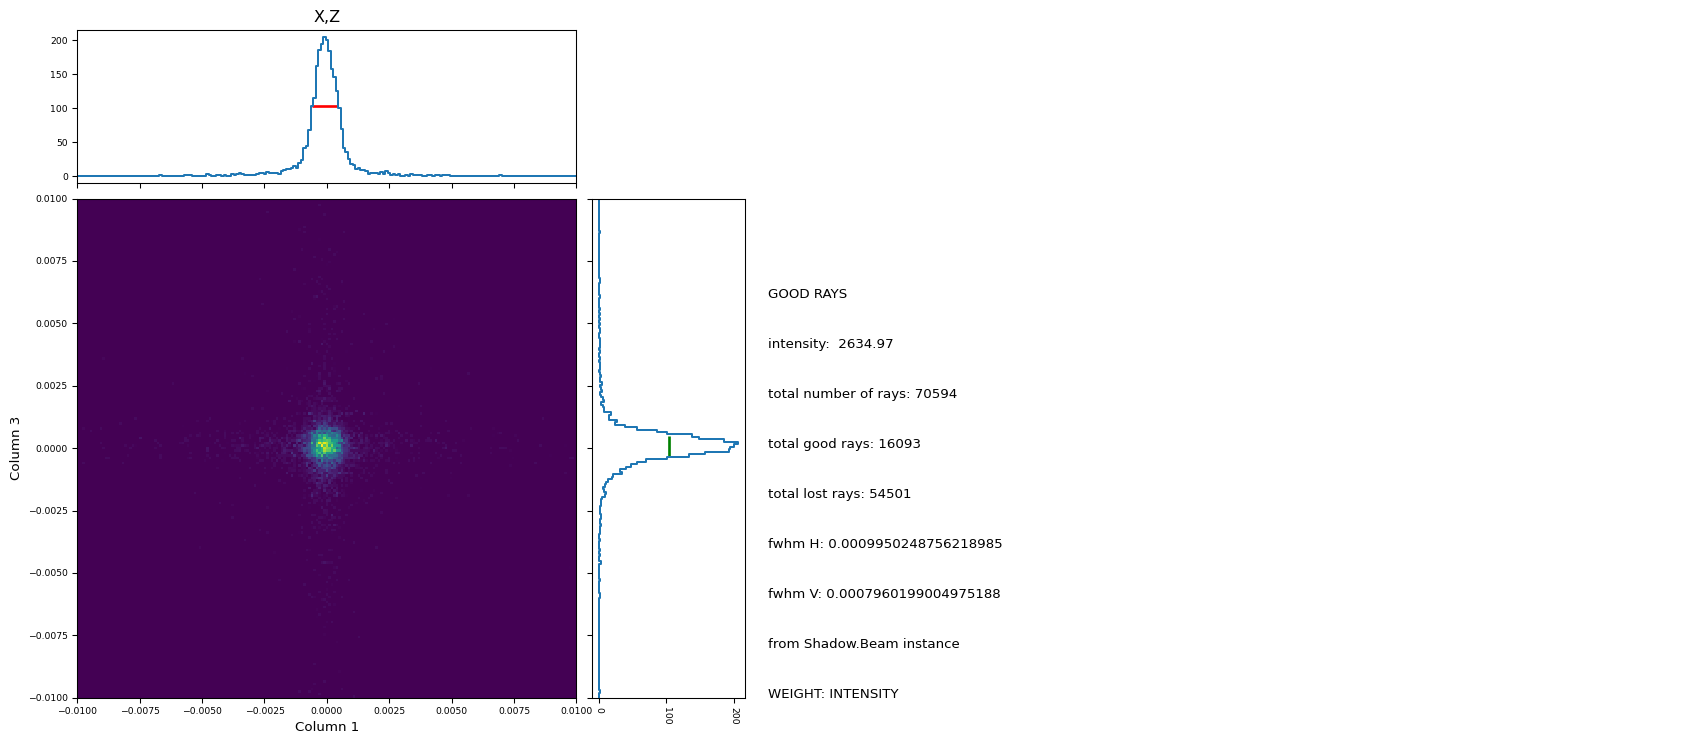

In [7]:
_ = plot_shadow_beam_spatial_distribution(output_beam, xrange=[-0.01, 0.01], yrange=[-0.01, 0.01])